# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Import required packages

In [2]:
from pathlib import Path
from infrarisk.src.network_recovery import *
import infrarisk.src.simulation as simulation
from infrarisk.src.physical.integrated_network import *
import infrarisk.src.recovery_strategies as strategies

from infrarisk.src.physical.interdependencies import *

from infrarisk.src.optimizer import *
import infrarisk.src.plots as model_plots

#import random

c:\Users\srijith\anaconda3\envs\redcar\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


## Create an IntegratedNetwork object

In [3]:
simple_network = IntegratedNetwork(name = "Simple")

### Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [4]:
MAIN_DIR = Path('../..')

network_dir= 'infrarisk/data/networks/in2'
water_folder = MAIN_DIR/f'{network_dir}/water'
power_folder = MAIN_DIR/f'{network_dir}/power'
transp_folder = MAIN_DIR/f'{network_dir}/transportation/'

# load all infrastructure networks
simple_network.load_networks(water_folder, 
                             power_folder, 
                             transp_folder, '1ph',
                             water_sim_type = "PDA")

Water network successfully loaded from ..\..\infrarisk\data\networks\in2\water/water.inp. The analysis type is set to PDA.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\..\infrarisk\data\networks\in2\power\power.json. Single phase power flow simulation will be used.

Transportation network successfully loaded from ..\..\infrarisk\data\networks\in2\transportation. Static traffic assignment method will be used to calculate travel times.


### Create a Networkx graph of the integrated infrastructure network.

In [5]:
simple_network.generate_integrated_graph()

Successfully added power network to the integrated graph...
Successfully added water network to the integrated graph...
Successfully added transportation network to the integrated graph...
Integrated graph successffully created.
Generating betweenness centrality...


Loading BokehJS ...

### Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [6]:
dependency_file = MAIN_DIR/f"{network_dir}/dependecies.csv"
simple_network.generate_dependency_table(dependency_file = dependency_file)
simple_network.dependency_table.wp_table

,water_id,power_id,water_type,power_type
0,W_WP9,P_MP1,Pump,Motor
1,W_R9,P_G3,Reservoir,Generator


In [7]:
simple_network.dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B1,T_J2,power,Bus,180.28
1,P_B2,T_J5,power,Bus,111.80
2,P_B3,T_J5,power,Bus,141.42
3,P_B4,T_J8,power,Bus,100.00
4,P_B5,T_J7,power,Bus,100.00


### Set failed components

In [8]:
scenario_folder = "scenarios/test1"
disruption_file = MAIN_DIR/f"{network_dir}/{scenario_folder}/disruption_file.csv"

simple_network.set_disrupted_components(disruption_file=disruption_file)
simple_network.get_disrupted_components()

['W_P21', 'W_WP9', 'T_L2', 'P_L5']

### Set initial crew locations

In [9]:
simple_network.deploy_crews(
    init_power_crew_locs=['T_J8'], 
    init_water_crew_locs=['T_J8'],
    init_transpo_crew_locs= ['T_J8']
    )

Power repair crews successfully deployed.
Water repair crews successfully deployed.
Transportation repair crews successfully deployed.


## Simulation of interdependent effects using a test scenario
### (a) Create NetworkRecovery

In [10]:
network_recovery = NetworkRecovery(simple_network, 
                                   sim_step=60, 
                                   pipe_close_policy="repair",
                                   pipe_closure_delay= 10, 
                                   line_close_policy="sensor_based_line_isolation",
                                   line_closure_delay= 10)

### (b) Create a simulation object

In [11]:
sim_step = (
    simple_network.wn.options.time.hydraulic_timestep
)  # initial_sim_step which will be updated during the simulation
bf_simulation = simulation.NetworkSimulation(network_recovery, sim_step)

### (c) Generation of random repair order

In [12]:
capacity_strategy = strategies.HandlingCapacityStrategy(simple_network)
capacity_strategy.set_repair_order()
repair_order = capacity_strategy.get_repair_order()

import os
if not os.path.exists(MAIN_DIR/f"{network_dir}/{scenario_folder}/capacity"):
    os.makedirs(MAIN_DIR/f"{network_dir}/{scenario_folder}/capacity")

In [13]:
#Generate a random repair order
# repair_order = network_recovery.network.get_disrupted_components()
# random.shuffle(repair_order)
print('Current repair order is {}'.format(repair_order))

Current repair order is ['T_L2', 'P_L5', 'W_WP9', 'W_P21']


### (d) Generation of event tables

In [14]:
bf_simulation.network_recovery.schedule_recovery(repair_order)

Repair T_L2: The transpo crew 1 is at T_J8 at t = 100.0 minutes. It takes 19 minutes to reach nearest node T_J2, the nearest transportation node from T_L2.
Repair P_L5: The power crew 1 is at T_J8 at t = 100.0 minutes. It takes 14 minutes to reach nearest node T_J5, the nearest transportation node from P_L5.
Repair W_WP9: The water crew 1 is at T_J8 at t = 100.0 minutes. It takes 23 minutes to reach nearest node T_J2, the nearest transportation node from W_WP9.
Repair W_P21: The water crew 1 is at T_J2 at t = 195.0 minutes. It takes 19.0 minutes to reach nearest node T_J5, the nearest transportation  node from W_P21  considering time for road link repair..
All restoration actions are successfully scheduled.
Total travel times: power: 14 mins, water: 42 min, transportation: 19 mins
Total recovery times: power: 264.0 mins, water: 770.0 min, transportation: 480.0 mins


In [15]:
#bf_simulation.network_recovery.event_table.to_csv("event_tbl.csv", sep = "\t", index = False)
bf_simulation.expand_event_table(1)

In [16]:
bf_simulation.network_recovery.event_table_wide

,component,disrupt_time,repair_start,functional_start
0,T_L2,6000,7200,28800
1,P_L5,6000,6840,15840
2,W_WP9,6000,7440,11760
3,W_P21,6000,12840,34440


### (e) Simulation of interdependent effects

In [17]:
resilience_metrics = bf_simulation.simulate_interdependent_effects(
    bf_simulation.network_recovery)

Time instances for which simulations will be performed:
 [60, 6060, 6660, 6900, 7260, 7500, 11700, 11820, 11940, 12900, 15780, 15900, 16020, 28740, 28860, 28980, 34380, 34500, 34620, 47820, 51900, 64860, 70500, 88500]
Simulating network conditions until 60 s
Simulation time:  60.0 ; Hydraulic time step:  60.0 ; Report time step:  60
Updating status of directly affected components between 60.0 and 6060.0...
******************

Simulating network conditions until 6060 s
Simulation time:  6060.0 ; Hydraulic time step:  60.0 ; Report time step:  60
Updating status of directly affected components between 6060.0 and 6660.0...
The pipe leak control for W_P21 is added between 6060 s and 6660.0 s
******************

Simulating network conditions until 6660 s
Simulation time:  6660.0 ; Hydraulic time step:  60.0 ; Report time step:  60
Updating status of directly affected components between 6660.0 and 6900.0...
The pipe leak control for W_P21 is added between 6660 s and 6900.0 s
****************

In [18]:
strategy = 'capacity'
bf_simulation.write_results(f"{MAIN_DIR}/{network_dir}/{scenario_folder}/{strategy}", 
                            resilience_metrics)

The simulation results successfully saved to ..\..\infrarisk\data\networks\in2\scenarios\test1\capacity


### (f) Calculation of resilience metric

In [19]:
resilience_metrics.calculate_power_resmetric(network_recovery)

The power Resilience Metric value based on ECS is 0.888 equivalent outage hours (EOH)
The power Resilience Metric value based on PCS is 0.131 equivalent outage hours (EOH)


In [20]:
resilience_metrics.calculate_water_resmetrics(network_recovery)

The water Resilience Metric value based on ECS is 1.598 equivalent outage hours (EOH)
The water Resilience Metric value based on PCS is 1.597 equivalent outage hours (EOH)


In [21]:
resilience_metrics.set_weighted_auc_metrics()

The weighted AUC value based on ECS is 1.243
The weighted AUC value based on PCS is 0.864


# Plot network performance during the disruption

### Overall system performance considering indirect effects

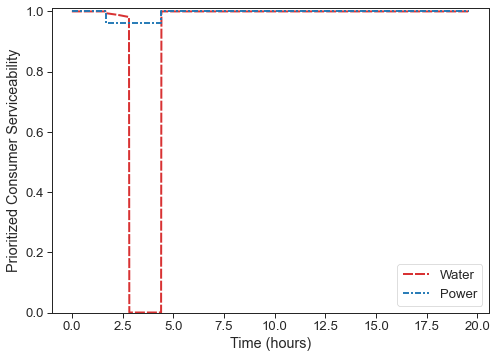

In [22]:
model_plots.plot_interdependent_effects(resilience_metrics, metric = 'pcs', title = False)

In [23]:
model_plots.plot_disruptions_and_crews(simple_network)

{'power': [], 'water': ['W_P21', 'W_WP9'], 'transpo': []}


Loading BokehJS ...